### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.


### Q2 answer
For modeling multivariate spike and slap regression, I will use the energy efficiency data from https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset The y variables are Heating Load and Cooling Loadn which represent the amount of heat energy that must be supplied or removed to maintain the desired temperature of the building. The x variables are the characteristics of the buildings,(X1: Relative Compactness, X2: Surface Area, X3: Wall Area, X4: Roof Area, X5: Overall Height, X6: Orientation, X7: Glazing Area and X8: Glazing Area Distribution) 
Among these 8 predictor varibles, I chose X1, X2, X3 and X4 as our final predictor variables.

In [2]:
import pandas as pd
import pymc as pm
import numpy as np
from sklearn.preprocessing import StandardScaler

building_data = pd.read_csv("ENB2012_data-Copy1.csv")
building_data.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
                  'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution',
                  'Heating_Load', 'Cooling_Load']
print(building_data.head())

   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  Heating_Load  \
0            2           0.0                          0         15.55   
1            3           0.0                          0         15.55   
2            4           0.0                          0         15.55   
3            5           0.0                          0         15.55   
4            2           0.0                          0         20.84   

   Cooling_Load  
0         21.33  
1         21.33  
2         21.33  
3         21.3

In [5]:
# Extract X and Y
X = building_data[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area']]
Y = building_data.iloc[:, -2:].values   # Heating_Load and Cooling_Load

# Optional: Standardize features
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

n, p = X_scaled.shape
m = Y_scaled.shape[1]

In [25]:
with pm.Model() as spike_and_slab_model:

    # Global inclusion probability
    p_incl = pm.Beta("p", alpha=1, beta=1)

    # Spike: binary inclusion indicators for each (predictor, output)
    spike = pm.Bernoulli("spike", p=p_incl, shape=(p, m))

    # Slab: real-valued coefficients
    slab = pm.Normal("slab", mu=0, sigma=10, shape=(p, m))

    # Combined coefficients
    beta = pm.Deterministic("beta", spike * slab)

    # Expected value for Y: matrix multiplication
    mu = pm.math.dot(X_scaled, beta)

    # Observation noise (shared across outputs)
    sigma = pm.Exponential("sigma", 1.0)

    # Likelihood: multivariate normal (independent outputs)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_scaled)
    

with spike_and_slab_model:
    idata1=pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, slab, sigma]
>BinaryGibbsMetropolis: [spike]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 335 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameteriz

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

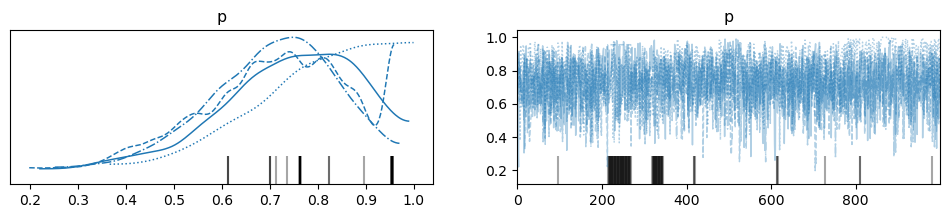

In [26]:
import matplotlib.pyplot as plt
import arviz as az

az.plot_trace(idata1, var_names='p')


From the graph above, the posterior p seems to favor the value from 0.5 to 0.9. Multiple chains have similar shapes, though some show slightly different peaks — possibly indicating some variation or weak multimodality.

Also, from the right plot, we can see that the mixing is well done since all chains are sampling from roughly the same region (between 0.4 and 1).

In [30]:
az.summary(idata1, round_to=5)

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",-1.52868,0.11614,-1.74024,-1.30465,0.00288,0.00184,1628.72308,2444.42329,1.00228
"beta[0, 1]",-1.70993,0.12175,-1.93429,-1.48871,0.00379,0.00242,1027.32480,1751.58888,1.00407
"beta[1, 0]",-0.60478,3.73630,-8.59022,8.33065,0.18803,0.98322,40.81646,66.35080,1.59250
"beta[1, 1]",-0.74550,1.81875,-2.67214,0.02024,0.43159,0.68809,8.10508,50.14235,1.78809
"beta[2, 0]",-0.24308,1.85062,-4.63440,3.72654,0.09316,0.48785,38.15106,67.49207,1.46771
"beta[2, 1]",-0.29454,0.90252,-0.79805,0.59890,0.21355,0.33986,10.25294,50.44915,1.38890
"beta[3, 0]",-1.72839,3.83233,-10.78232,6.52963,0.19283,1.01033,37.99653,67.49207,1.46160
"beta[3, 1]",-1.77790,1.86821,-2.79966,0.00000,0.44224,0.70398,10.52303,27.86706,1.38582
p,0.73938,0.14573,0.49092,0.99997,0.02095,0.00288,38.65834,44.98958,1.07267
sigma,0.41910,0.00758,0.40531,0.43376,0.00016,0.00014,2134.01407,2182.19857,1.00726


Even though, we checked that the chains for p are mixed well. The summary statistics for some variables shows slighly bad indicates. Except beta[0,0], beta[0,1], slab[0,0], slab[0,1] p and sigma with good convergence(rhat $\approx$ 1), most of variables show poor mixing as rhat value is far from value of 1. 

Furthermore, since we define $\beta_{i,j} = slab_{i,j} * spike_{i,j}$, if spike shows low effective sample size ,or slab shows high posterior vairance or poor mixing, the corresponding beta will inherit the noise or instability. 


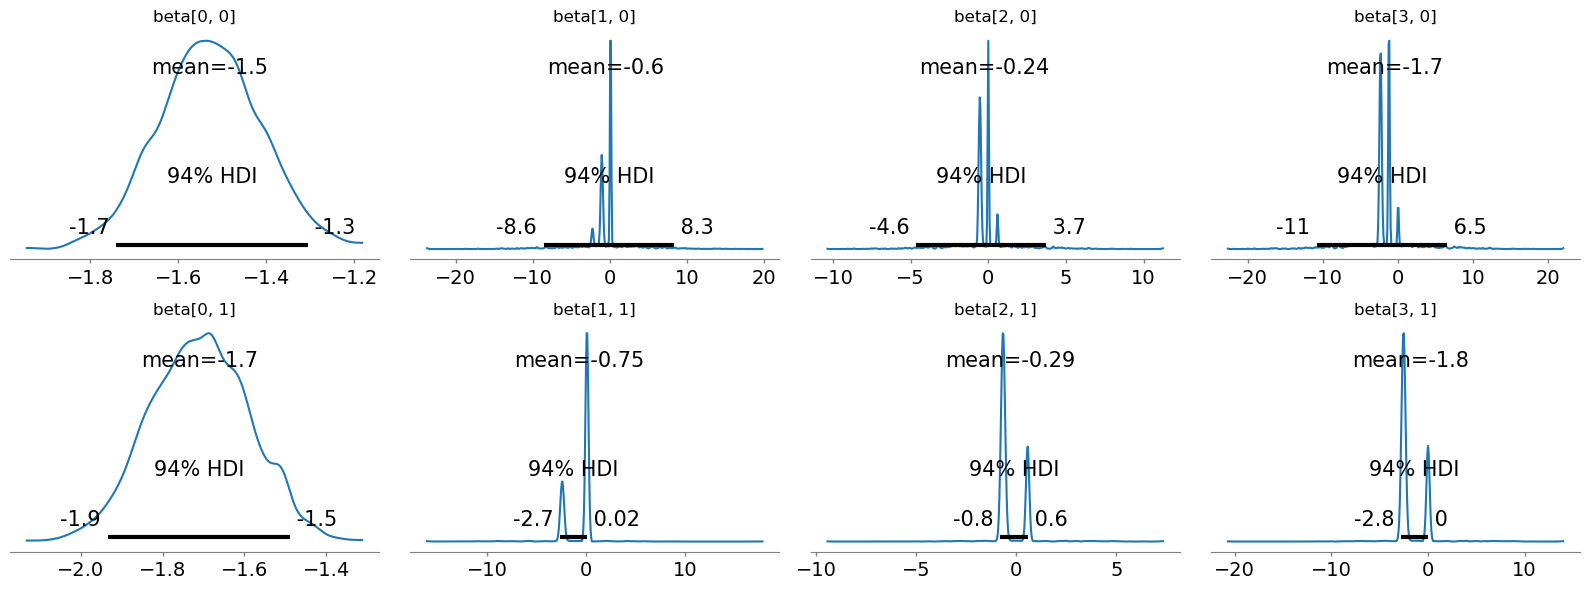

In [41]:
fig, axs = plt.subplots(2, 4, figsize=(16, 6))  # 2 rows (outputs) × 4 columns (predictors)

for i in range(4):  # 4 predictors
    for j in range(2):  # 2 outputs
        ax = axs[j, i]  # row = output (j), column = predictor (i)
        az.plot_posterior(idata1, var_names=["beta"],
                          coords={"beta_dim_0": i, "beta_dim_1": j},
                          ax=ax)
        ax.set_title(f"beta[{i}, {j}]")

plt.tight_layout()

As a result, we can conclude that only two coefficients beta[0,0] and beta[1,0] are the possible coefficients for our regression model. Since they have credible intervals of [-1.74,-1.3] and [-1.934,-1.4887] accordingly, their effect on outcome variable is not zero. From the context of our data, as relative compactness of buildling increases, the heating load decreased by mean of 1.53 and the cooling load decreasd by mean of 1.7. 

So we can conclude that the relative compactness of the building is larger, then the amount of heat energy supplied for heating and removed for cooling is decreased. 

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples

### Q3 Answer

* Horseshoe prior

For each regression coefficient $\beta_{j,k}$:
$$\beta_{j,k}\sim N(0,\lambda_{j,k}^2*\tau^2)$$
where $\lambda_{j,k}\sim HalfCauchy(0,1)$ and 
$\tau \sim HalfCauchy(0,1)$ 

**Note: $\lambda$ is local shrinkage and $\tau$ is global shrinkage

In here, we will use the same dataset from the spike and slab model. 

In [6]:
with pm.Model() as horseshoe_model:

    # Global shrinkage
    tau = pm.HalfCauchy("tau", beta=1)

    # Local shrinkage (one per beta)
    lam = pm.HalfCauchy("lam", beta=1, shape=(p, m))

    # Horseshoe prior on coefficients
    sigma_beta = pm.Deterministic("sigma_beta", tau * lam)
    beta = pm.Normal("beta", mu=0, sigma=sigma_beta, shape=(p, m))

    # Linear predictor
    mu = pm.math.dot(X_scaled, beta)

    # Likelihood
    sigma = pm.Exponential("sigma", 1.0)
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_scaled)

with horseshoe_model:
    idata2=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lam, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

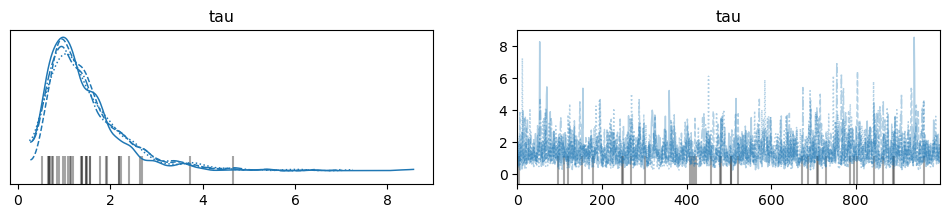

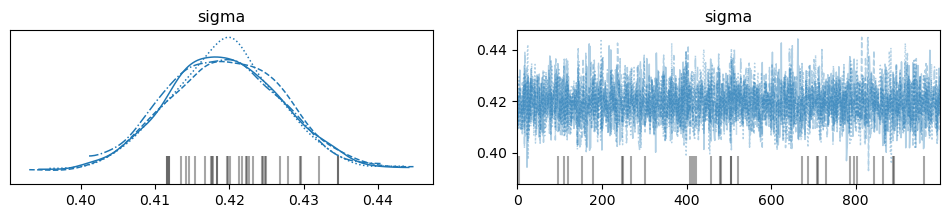

In [21]:
import matplotlib.pyplot as plt
import arviz as az

az.plot_trace(idata2, var_names="tau")
az.plot_trace(idata2, var_names=["sigma"])

From the above graphs, we can see that the posterior tau and sigma for each chain looks very similar as tau posterior approximately concentrates at 1 and sigma posterior concetrates arount 0.42. But the time-series graph for chain mixing for tau looks abit poor. 

In [13]:
az.summary(idata2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",-1.50814,0.11928,-1.73843,-1.29712,0.00193,0.00203,3805.18475,2757.05198,1.00000
"beta[0, 1]",-1.69159,0.12338,-1.92282,-1.46023,0.00209,0.00236,3491.65447,2507.47131,1.00081
"beta[1, 0]",-1.09762,1.03026,-2.93792,0.58638,0.03927,0.03992,693.92713,1189.62232,1.00165
"beta[1, 1]",-1.24067,1.12207,-3.13651,0.68787,0.05294,0.04188,472.34667,760.31984,1.01041
"beta[2, 0]",0.01133,0.50737,-0.77735,0.96068,0.01940,0.01997,688.43817,1172.33899,1.00146
"beta[2, 1]",-0.04091,0.55662,-1.01943,0.89449,0.02636,0.02126,468.96771,751.40816,1.01033
"beta[3, 0]",-1.20213,1.05086,-2.83821,0.73965,0.04014,0.04123,689.58527,1214.16900,1.00141
"beta[3, 1]",-1.25157,1.15166,-3.30137,0.64031,0.05449,0.04393,470.00271,773.87408,1.01035
"lam[0, 0]",2.05973,2.55308,0.19108,5.21505,0.05411,0.22329,2662.27153,2404.32377,1.00187
"lam[0, 1]",2.42771,3.87311,0.19290,6.07945,0.10377,0.60089,2168.29766,1820.71506,1.00120


From the summary statistcs, lam[1–3, :] values are much closer to 1 than lam[0, :], and it suggests that the horseshoe prior is shrinking beta[1–3, :] more than beta[0, :]. Furthermore, since tau has mean of 1.47 and sd of 0.84, it indicates moderate global shrinkage in our model.

Also, we define that $\sigma_{\beta} = \lambda * \tau$.
we can see that sigma_beta[0, :] is relatively large, and it indicates beta[0,:] was allowed to be large.
Others are more mixed, and it suggests that some coefficients being nudged toward zero

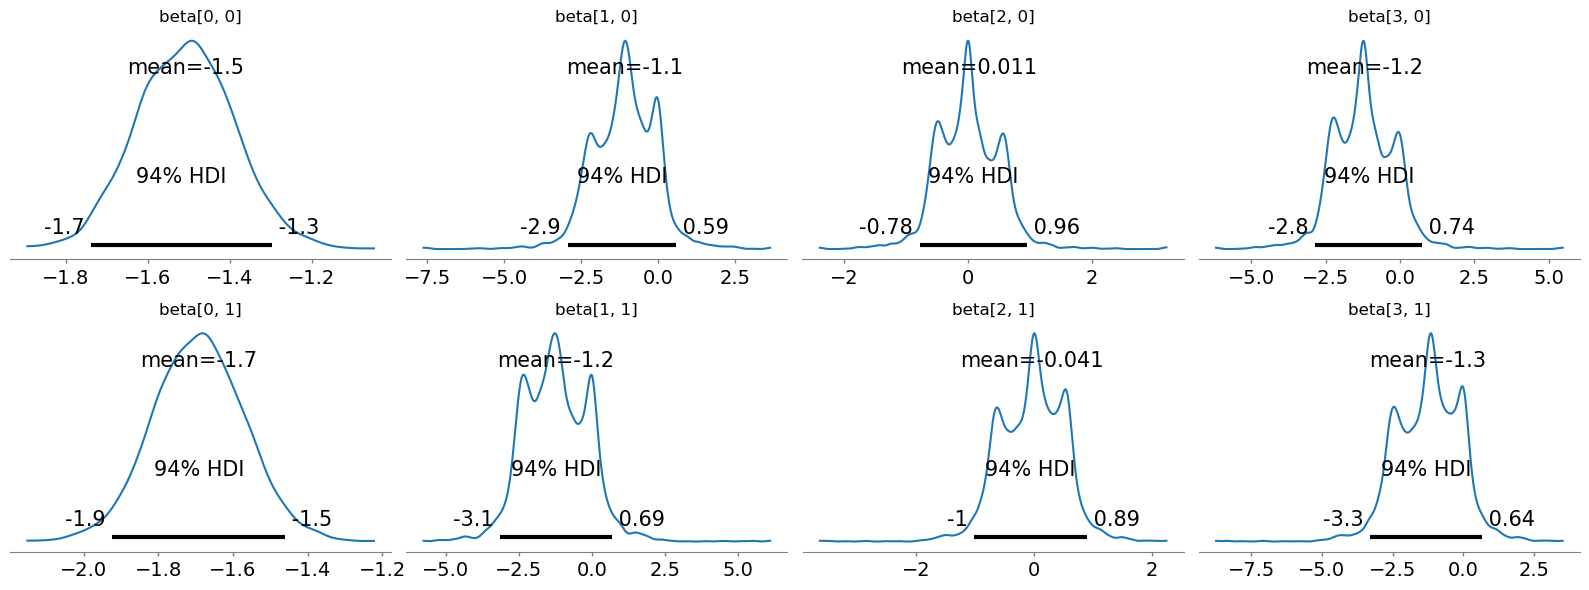

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(16, 6))  # 2 rows (outputs) × 4 columns (predictors)

for i in range(4):  # 4 predictors
    for j in range(2):  # 2 outputs
        ax = axs[j, i]  # row = output (j), column = predictor (i)
        az.plot_posterior(idata2, var_names=["beta"],
                          coords={"beta_dim_0": i, "beta_dim_1": j},
                          ax=ax)
        ax.set_title(f"beta[{i}, {j}]")

plt.tight_layout()

Similar to the result from the spike-slab model, the beta[0,0] and beta[1,0] shows well-mixing with r-hat is almost equal to 1. Also their mcse is very small as 0.00193 and 0.00209 accordingly. Furthermore, their credible interval are [-1.73843, -1.29712] and	[-1.92282, -1.46023] accordingly, and it suggests that the first predictor (relative compactness) is the only predictor that has an effect on our outcome variables(heating and cooling load), and they have negative effect on our outcome variables.
